# Recurrent Neural Networks as Optimal Mesh Refinement Strategies

Based on the paper [Recurrent Neural Networks as Optimal Mesh Refinement Strategies (2019)](https://arxiv.org/pdf/1909.04275.pdf) by Jan Bohn and Michael Feischl. 

**Author:** Viet Duc Nguyen

**Date:** 02/06/2020

In [0]:
import numpy as np

## Basic Building Blocks

**Lemma 6.**
Let $\delta \in 2^{\mathcal E}$ and $n = |\log_2(\delta)|$. Let $\mathbf x = (x,0,...,0) \in \mathbb R^n_{\delta}$. Then, $\mathbf y = \mathrm{IF}(\mathbf x)$ is defined as

$$
    y_n = \begin{cases}
        1 &\quad x \geq 2^{-n}\\
        0 &\quad x \leq 0
    \end{cases}.
$$

The neural network can be constructed as follows

\begin{align*}
    \begin{cases}
        y_{0} &= 0 \\
        y_i &= \min(2z_i, 1) \\
        z_i &= \max(y_{i-1} + x_i, 0)
    \end{cases}
    \quad \forall i=1,...,n.
\end{align*}

Note that if $0 < x < \delta$, then $y_n < 1$ due to $y_n= 2^nx < 2^n \delta = 2^n 2^{-n} = 1$.

---

Next, we would like to generalize **Lemma 6**. Let $\delta \in 2^{\mathcal E}$ and $x' \in [0,M]$ for a fixed constant $M \in \{ 2^k : k \in \mathbb N\}$. Choose $n = |\log_2(\delta)| + \log_2(M)$. We construct an $\mathrm{IF}$ operator with $\mathbf y = \mathrm{IF}(\mathbf x, x')$ that satisfies

$$
    y_n = \begin{cases}
        x' &\quad x \geq 2^{-n}\\
        0 &\quad x \leq 0
    \end{cases}.
$$

We can use the same building block as before where we only need to adjust $y_i$:

\begin{align*}
    \begin{cases}
        y_{0} &= 0 \\
        y_i &= \min(2z_i, x') \\
        z_i &= \max(y_{i-1} + x_i, 0)
    \end{cases}
    \quad \forall i=1,...,n.
\end{align*}

Since we increased the size of the input vector $\mathbf x \in \mathbb R^n_{\delta}$ to $n =  |\log_2(\delta)| + \log_2(M)$ instead of $n =  |\log_2(\delta)|$ we ensured that $2z_n \geq M \geq x'$, which implies that $y_n = \min(2z_n, x') = x'$.

In the paper, $n$ is chosen such that $n \geq 52 + \log_2(\delta) + \log_2(M)$. This is still not clear to me.

**Lemma 6.1.**

In [0]:
"""Return max(x,0)"""
def ReLU(x):
    return np.fmax(x,0)

"""Return max(x,y)"""
def MAX(x, y):
    return ReLU(x-y) + y

"""Return min(x,0) = -ReLU(-x,0)"""
def MIN(x, y=0):
    return -ReLU(-(x-y)) + y

"""
IF(x): Returns x' if x >= 2^(-n)
"""
def IF(x, x_prime = 1):
    # Initialization
    n = x.shape[0]
    y = np.empty(n+1)
    y[-1] = 0

    #if n - 52 - np.log2(x_prime) >= -np.log2(x[0]):
    #    print("Warning IF(x,x'): Increase dimension of input vector n")

    for i in range(n):
        z = ReLU(y[i-1] + x[i])
        y[i] = MIN(2*z, x_prime)

    return y[:n]

In [0]:
"""Return vector of dimension `length` with x[0] = x0"""
def VECTOR(x0, length = 52):
    x = np.zeros(length, dtype=np.float64)
    x[0] = x0
    return x

**Remark 7.**
The goal of this lemma is to emulate a non-continuous function with a RNN. The precision error of a *double* number $x \approx 1$ is limited by $2^{-52}$. Hence, for $x < 2^{-52}$ the calculation $\tilde x = (x +_{\mathrm{double}}1)-1$ will yield $\tilde x = 0$. This implies that the application of $\mathrm{IF}$ in the following way

$$
    \mathbf y = \mathrm{IF}((\mathbf x +_{\mathrm{double}}1) - 1)
$$

with an input size of $n=52$ satisfies

$$
    y_n = \begin{cases}
        1 &\quad x \geq 2^{-52} \\
        0 &\quad x < 2^{-52}
    \end{cases}.
$$

Note that $x$ is in bit representation. If $\tilde x = 2^{-52} - \epsilon$ and $\epsilon > 0$ is small enough such that $\tilde x = 2^{-52}$ it still holds $y_n = 1$ although $x < 2^{-52}$ in real representation.

In [0]:
# x0 is equal 2**-52
x0 = np.float64(2**-52) # 2.220446049250313e-16
x = np.zeros(52, dtype=np.float64)
x[0] = (x0 + 1)-1
assert IF(x)[-1] == 1, "{} is not equal 1".format(IF(x)[-1])

# x is a little bit smaller than 2**-52
x0 = np.float64(2**-52 - 0.000000000000001) # -7.779553950749688e-16
x = np.zeros(52, dtype=np.float64)
x[0] = (x0 + 1)-1
assert IF(x)[-1] == 0, "{} is not equal 0".format(IF(x)[-1])

# x0 is equal 2**-52 because the difference is too small
x0 = np.float64(2**-52 - 0.0000000000000001) # 2.220446049250313e-16
x = np.empty(52, dtype=np.float64)
x[0] = (x0 + 1)-1
assert IF(x)[-1] == 1, "{} is not equal 1".format(IF(x)[-1])

*Notation:* $\mathbb R_\delta = \{0\} \cup \mathbb R \setminus (-\delta, \delta)$ for any real number $\delta \in \mathbb R_{>0}$.

In the following, we need to build the following function

$$
    x \mapsto \begin{cases}
        1, & \quad x \geq \alpha  \\
        0, & \quad x < \alpha
    \end{cases}.
$$

As noted in the previous remark, we make use of the rounding error of the double arithmetic. Consider IEEE 757 double precision. We have **52 bits for the mantissa** and **11 bits for the exponent**. The exponent $e$ takes values in $e \in \{ -1022,...,1023 \}$. Note that $-1023$ and $1024$ are reserved. IEEE 757 doubles are always normed, i.e. there is always a leading one.

```
    1  . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
    ^    1 2 3 4 5 6 7 8 9 ........................... 52 
    |
  fixed                        52 bits
```

**Lemma 8.** We assume double arithmetic. There exists a DNN $\hat{IF}$ such that any input $\mathbf x = (x, 0,...,0) \in \mathbb R_{\delta}^{n}$ with precision $\delta = 2^{\mathcal E}$ and $x' \in [0,M]$ results in $\mathbf y = \hat{IF}(\mathbf x, x')$ with

$$
    y_n = \begin{cases}
        x' &\quad x > 0 \\
        0 & \quad x \leq 0 
    \end{cases}.
$$

*Proof.* We define 

$$\hat{\mathrm{IF}}(\mathbf x, x') = \mathrm{IF}(\underbrace{(x + \delta 2^{52})}_{(*)} - \delta 2^{52}, x').$$

Consider the term $(*)$. Let $x < \delta$. If one computes $x + \delta 2^{52}$, then the precision of 52 bits doesn't suffice to obtain an accurate result of $x + \delta 2^{52}$. Here is an illustration why: assume the mantissa can hold 3 bits.
```
 Variable     | Value
-------------------------------------------------
        delta | 1 . 0 0 0 x 2^5 = 0 0 0 1 0 0 0 0
              |  
            x | 1 . 0 0 0 x 2^4 = 0 0 0 0 1 0 0 0
+ 2^3 * delta | 1 . 0 0 0 x 2^8 = 1 0 0 0 0 0 0 0
-------------------------------------------------
                1 . 0 0 0 x 2^8 = 1 0 0 0 1 0 0 0
                                    ^ ^ ^
                            We can only hold 3 bits!
```
So, we get

$$
    (x + \delta 2^{52}) - \delta 2^{52} = \begin{cases}
        x & x \geq \delta\\
        0 & x < \delta
    \end{cases}
$$

Note that $x \geq \delta$, and therefore 
$$
    (x + \delta 2^{52}) - \delta 2^{52} = \begin{cases}
        x & x > 0\\
        0 & x \leq 0
    \end{cases}.
$$

Now apply $\mathrm{IF}$ and one obtains
$$
    \mathrm{IF}( (x + \delta 2^{52}) - \delta 2^{52}, x') = \begin{cases}
        x' & x \geq 2^{-n}\\
        0 & x \leq 0
    \end{cases}
$$
by definition of $\mathrm{IF}$. We know that $x \geq \delta \overset{(!)}{\geq} 2^{-n}$. Thus, $n \geq |\ln (\delta)|$.

### Lemma 8: $\hat{\mathrm{IF}}$

In [0]:
def IF_HAT(x, x_prime):
    assert np.isscalar(x_prime)

    n = x.shape[0]
    delta = 2**-n

    z = (x + delta * 2**52) - delta * 2**52
    y = IF(z, x_prime)

    return y

"""
x_prime can be a vector
"""
def IF_HAT_MULTIDIMENSION(x, x_prime):
    n = x_prime.shape[0]
    y = np.zeros(n)
    for i in range(n):
        y[i] = IF_HAT(x, x_prime[i])[-1]
    return y

In [0]:
x = np.zeros(20, dtype=np.float64)
x[0] = 0.0001

assert IF_HAT(x, 42)[-1] == 42

x_prime = np.array([1,2,3])
assert np.array_equal(IF_HAT_MULTIDIMENSION(x, x_prime), x_prime)

**Lemma 9.** We assume double arithmetic. There exists a DNN $\tilde{IF}$ such that any input $\mathbf x = (x, 0,...,0) \in \mathbb R_{\delta}^{n}$ with precision $\delta = 2^{-n}$ and $x' \in [0,M]$ results in 

$$
    y_n = \begin{cases}
        x' &\quad x \geq 0 \\
        0 & \quad x < 0 
    \end{cases}.
$$

In [0]:
def IF_TILDE(x, x_prime):
    return x_prime - IF_HAT(-x, x_prime)

In [0]:
x = np.zeros(20, dtype=np.float64)
x[0] = 0.000

IF_TILDE(x, 42)[-1]

42.0

## Emulate the error estimate

In [0]:
"""Saw tooth function"""
def g(x):
    return 2 * ReLU(x) - 4 * ReLU(x - 0.5) + 2 * ReLU(x-1)

### Theorem 10: Square

**Theorem 10.** For every $n \in \mathbb N$, there exists a RNN SQUARE such that the output $\mathbf y = \mathrm{SQUARE}(\mathbf x) = (y_1,...,y_{n-1}, \tilde{x_0^2})$ for an input vector $\mathbf x = (x_0,0,...,0) \in [0,1]^n$ satisfies

$$
    y_n = x_0 - \sum^n_{j=1} \frac{g^{(j)}(x_0)}{4^j} \approx x_0^2 \quad \text{and} \quad |y_n - x_0^2| \leq \frac{2x_0}{4^n},
$$

where $g^{(j)}(x_0) = \underbrace{g(g(...g(x_0)))}_{\text{$j$-times}}$.

In [0]:
"""Return x**2"""
def SQUARE(x):
    n = x.shape[0]
    x0 = x[0]
    
    x_prime = np.empty(n+1)
    x_prime[-1] = x0
    for i in range(n):
        x_prime[i] = g(x_prime[i-1])
    x_prime = x_prime[:-1]

    y = np.empty(n+1)
    y[-1] = 0
    for i in range(n):
        y[i] = x_prime[i] + 4*y[i-1]
    y = y[:-1]
    y_n = y[-1]

    z = np.empty(n+1)
    z[-1] = y_n
    for i in range(n+1):
        z[i] = z[i-1] / 4
    z = z[:-1]
    z_n = z[-1]

    return x0 - z_n

In [0]:
# Test SQUARE(x)
print("Approximation of x^2.")
x = np.zeros(52, dtype=np.float64)
x[0] = 0.01
SQUARE(x) # result should be around 0.0001

Approximation of x^2.


0.00010000000000000113

**Proposition 11.** There exists a RNN MULTIPLY

**Proposition 11(a).** Let $n \in \mathbb N$. Given $\mathbf x = (x_0,0,...,0) \in \mathbb R^{n}$ with $x_0 \in [-2^{\frac{n}{2}}, 2^{\frac{n}{2}}]$ there exists a RNN such that the output $\mathbf y = \mathrm{SCALE}(\mathbf x)$ satisfies 

$$
    y_n = x_0 2^{-d} < \frac{1}{4} + 2^{-52} \quad \text{for a suitable $d \in \mathbb N$.}
$$

In other words, we construct a RNN that scales any input $x_0$ to a value below $\frac{1}{4} + 2^{-52}$, where $2^{-52}$ is our given precision. The last entry of the vector $\mathbf y$ holds the downscaled value $x_0$, and the integer $d$ holds how often the value $x_0$ needs to be divided in half such that $x_0 < \frac{1}{4}$.

Initialize $\mathbf x' \in \mathbb R^{n+1}$ and $\mathbf r \in \{0,1\}^{n+1}$.

\begin{align*}
    \begin{cases} 
        x'_{0} &= x_0 \\
        r'_{0} &= 0 \\
        x_i' &= \tilde{IF}\left(x'_{i-1} - \frac{1}{4}, \frac{x'_{i-1}}{2}\right) + \hat{IF}\left( \frac{1}{4} - x'_{i-1}, x'_{i-1} \right) \\
        r_i' &= \tilde{IF}\left(x'_{i-1} - \frac{1}{4}, 1\right)
    \end{cases} \quad \forall i = 1,...,n
\end{align*}

In the end, $x'_n$ holds the desired result, and $d = ||\mathbf r||_1$.

In [0]:
def SCALE(x):
    n = x.shape[0]
    x0 = x[0]
    x_prime = np.empty(n+1)
    x_prime[-1] = x0
    r = np.empty(n+1)
    r[-1] = 0

    for i in range(n):
        z = np.zeros(n)
        z[0] = x_prime[i-1] - 0.25
        z_prime = np.zeros(n)
        z_prime[0] = 0.25 - x_prime[i-1]

        x_prime[i] = (IF_TILDE(z, x_prime[i-1]/2) + IF_HAT(z_prime, x_prime[i-1]))[-1]
        r[i] = IF_TILDE(z, 1)[-1]

    x_prime = x_prime[:-1]
    r = r[:-1]

    return x_prime[-1], r

In [0]:
# Test SCALE(x)
print("Downscaling of 42")
x = np.zeros(52)
x[0] = 0.5
x_prime, r = SCALE(x)
print("Value: {}\nNumber of divisions: {}".format(x_prime, np.sum(r)))

Downscaling of 42
Value: 0.125
Number of divisions: 2.0


In [0]:
"""Return x*y for non-negative x and y"""
def MULTIPLY_NONNEGATIVE(x,y):
    n = x.shape[0]
    assert y.shape[0] == n
    x0 = x[0]
    y0 = y[0]

    # Scaling to <0.25
    x_scaled, r_x = SCALE(x)
    y_scaled, r_y = SCALE(y)
    d_x = np.sum(r_x)
    d_y = np.sum(r_y)
    
    # Compute the product of the scaled values
    xy_scaled = 0.5 * (SQUARE(VECTOR(x_scaled+y_scaled)) - SQUARE(VECTOR(x_scaled)) - SQUARE(VECTOR(y_scaled)))

    # Reverse the scaling
    z = np.empty(n+1)
    z[-1] = xy_scaled
    for i in range(n):
        z[i] = (IF_HAT(VECTOR(r_x[i]), 2*z[i-1]) + IF_HAT(VECTOR(r_y[i]), 2*z[i-1]) + + IF_TILDE(VECTOR(-r_x[i] - r_y[i]), z[i-1]))[-1]
    z = z[:-1]
    product = z[-1]

    return product

In [0]:
print("Compute the product of 100 times 100.")
x = np.zeros(52)
y = np.zeros(52)
x[0] = 10
y[0] = 10
print("Result is {}".format(MULTIPLY_NONNEGATIVE(x,y)))

Compute the product of 100 times 100.
Result is 100.0


So far, we have only realized the multiplication operator for non-negative inputs. For general input, one can use the following formula

$$
    x \dot y = (x_+ - x_-)\cdot(y_+ - y_-) = x_+y_+ - x_+y_- - x_-y_+ + x_-y_-.
$$

In [0]:
def MULTIPLY(x,y):
    x_pos = VECTOR(ReLU(x))
    x_neg = VECTOR(ReLU(-x))
    y_pos = VECTOR(ReLU(y))
    y_neg = VECTOR(ReLU(-y))

    return MULTIPLY_NONNEGATIVE(x_pos, y_pos) - MULTIPLY_NONNEGATIVE(x_pos, y_neg) - MULTIPLY_NONNEGATIVE(x_neg, y_pos) + MULTIPLY_NONNEGATIVE(x_neg, y_neg)

In [0]:
assert MULTIPLY(-10,-10) == -10 * -10
assert MULTIPLY(10,-10) == -10 * 10 
assert MULTIPLY(-10,10) == -10 * 10
assert MULTIPLY(10,10) == 10 * 10
assert MULTIPLY(10,0) == 0
assert MULTIPLY(0,10) == 0
assert MULTIPLY(-10,0) == 0
assert MULTIPLY(0,-10) == 0
assert MULTIPLY(0,0) == 0

In [0]:
def ABS(x):
    return ReLU(x) + ReLU(-x)


**Lemma 13.** Let $T \subset \mathbb R^d$, $d \in \mathbb N$. Then, the diameter of $T$ is defined as

$$
    \mathrm{diam}_\infty(T) = \max_{x,y \in T} || x-y||_\infty,
$$

where

$$
    ||x-y||_\infty = \max_{i = 1,...,d}(||x_i - y_i||).
$$


In [0]:
def INFINITY_NORM(x):
    n = x.shape[0]
    y = np.empty(n)
    y[0] = ABS(x[0])

    for i in range(1,n):
        y[i] = MAX(ABS(x[i]),y[i-1])
    
    return y[-1]

In [0]:
x = np.array([-100000000,4,-2,-1,-4,-6,-7,-7,-5,-100])
INFINITY_NORM(x)

100000000.0

In [0]:
def DIAM(T):
    size = T.shape[0]
    y = np.empty(np.math.factorial(size - 1) + 1)
    y[-1] = -np.inf
    c = 0

    for i in range(size):
        for j in range(i+1,size):
            y[c] = MAX(y[c-1], INFINITY_NORM(T[i]-T[j]))
            c = c + 1
    y = y[:-1]

    return y

In [0]:
T = np.array([
    np.array([500,0,100]), 
    np.array([1,1,1]), 
    np.array([-1000,1,10000000]), 
    np.array([1,1,-9999999999])
])
DIAM(T)

array([4.99000000e+02, 9.99990000e+06, 1.00000001e+10, 1.00000001e+10,
       1.00000001e+10, 1.00100000e+10])

## Dörfler Marking

###Lemma 17: CHOOSE and F 
Given a precision $\delta \in 2^{\mathcal E + 52}$, there exists a RNN CHOOSE such that for any input $\mathbf x \in \mathbb R^n_{\delta +} \cap [0,M]^n$ and $z \in \mathbb R_{\delta}$ results in an output $\mathbf y = \mathrm{CHOOSE}(\mathbf x, z)$ with 
$$
    \mathbf y = \begin{cases}
        \mathbf x, \quad &{z \geq 0} \\
        0 & {z < 0}
    \end{cases}.
$$

*Proof.* Use $\tilde{\mathrm{IF}}$ with a precision $\delta 2^{-52}$, and use it in the following way
$$
    F(x,y) = \max(x-y,0) + \tilde{\mathrm{IF}}(x-y, y)= \begin{cases}
        x, \quad x \geq y \\
        0, \quad x < y
    \end{cases}.
$$
Note that for $\tilde{\mathrm{IF}}(x-y, y)$ to work it must hold that $x-y$ has a precision in $2^{\mathcal E}$. Since $|x-y| \geq \delta 2^{-52}$ it follows $\delta \in 2^{\mathcal E + 52}$.

Now set
$$
    y_i = F(x_i + z, x_i) - \max(z,0).
$$

In [0]:
"""
Returns x if x >= y
"""
def F(x,y):
    assert np.isscalar(y)

    if np.isscalar(x):
        return MAX(x-y, 0) + IF_TILDE(VECTOR(x-y, length = 52), y)[-1] # returns a scalar

    n = x.shape[0]    
    output = np.zeros(n)
    for i in range(n):
        output[i] = MAX(x[i]-y, 0) + IF_TILDE(VECTOR(x[i]-y, length = 52), y)[-1] # returns a scalar
    return output

"""Returns x if z >= 0"""
def CHOOSE(x, z):
    n = x.shape[0]
    y = np.zeros(n)
    for i in range(n):
        y[i] = F(x[i] + z, x[i]) - MAX(z,0)
    return y # returns a vector

In [0]:
x = np.ones(52)
y = 0.1
print("Should return x if y >= 0")
CHOOSE(x, y)

Should return x if y >= 0


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

###Lemma 18: $\tilde{\mathrm{CHOOSE}}$
 Given a precision $\delta \in 2^{\mathcal E + 52}$, there exists a RNN $\tilde{\mathrm{CHOOSE}}$ such that for any input $\mathbf x \in \mathbb R^n_{\delta +} \cap [0,M]^n$ and $z \in \mathbb R_{\delta}$ results in an output $\mathbf y = \tilde{\mathrm{CHOOSE}}(\mathbf x, z)$ with 
$$
    \mathbf y = \begin{cases}
        \mathbf x, \quad &{z > 0} \\
        0 & {z \leq 0}
    \end{cases}.
$$

*Proof.* Use $\tilde{\mathrm{IF}}$ with a precision $\delta 2^{-52}$, and use it in the following way
$$
    F(x,y) = \max(x-y,0) + \hat{\mathrm{IF}}(x-y, y)= \begin{cases}
        x, \quad x > y \\
        0, \quad x \leq y
    \end{cases}.
$$

In [0]:
"""Returns x if z >= 0"""
def CHOOSE_TILDE(x, z):
    def F(x,y):
        return MAX(x-y, 0) + IF_HAT(VECTOR(x-y, length = 52), y)[-1]
    n = x.shape[0]
    y = np.zeros(n)
    for i in range(n):
        y[i] = F(x[i] + z, x[i]) - MAX(z,0)
    return y

In [0]:
x = np.ones(52)
z = 1
print("Should return x if z > 0")
assert np.array_equal(CHOOSE_TILDE(x, z), np.ones(52))
print("Passed")

x = np.ones(52)
z = 0
print("Should return x if z > 0")
assert np.array_equal(CHOOSE_TILDE(x, z), np.zeros(52))
print("Passed")

Should return x if z > 0
Passed
Should return x if z > 0
Passed


###Lemma 19: NONZERO
Given a precision $\delta \in 2^{\mathcal E}$, there exists a RNN $\mathrm{NONZERO}$ such that for any input $\mathbf x, \mathbf x' \in (\mathbb R_{\delta +} \cap [0,M])^n$ the output $\mathbf y = \mathrm{NONZERO}(\mathbf x, \mathbf x')$ satisfies

\begin{align*}
    \forall j \in \{ i,...,n \}: y_j = x_i , \text{where $i$ is the first index with $x_i \neq 0$ and $x_i' = 0$}
\end{align*}
and 
\begin{align*}
    \forall j \in \{ 1,...,i-1 \}: y_j = 0.
\end{align*}

*Example.* $\mathbf x = (0,1,2,3,4,5)$ and $\mathbf x' = (0,1,2,0,4,5)$. Then, $\mathbf y = \mathrm{NONZERO}(\mathbf x, \mathbf x') = (0, 0, 0, 3, 3, 3)$.

*Proof.* Use the building block

$$
    y_i = B(x_i, x_i', y_{i-1}) = y_{i-1} + F(x_i - y_{i-1}, x_i) - \hat{\mathrm{IF}}(F(x_i' - y_{i-1}, x_i'), y_{i-1} + F(x_i - y_{i-1}, x_i))
$$

In [0]:
def NONZERO(x, x_prime):
    """
    x, x_prime, y: scalar values
    Returns: scalar
    """
    def B(x, x_prime, y):
        return y + F(x-y,x) - IF_HAT(VECTOR(F(x_prime - y, x_prime)), y + F(x-y,x))[-1]
    assert x.shape == x_prime.shape
    n = x.shape[0]
    y = np.zeros(n+1)
    y[-1] = B(0,0,0)
    for i in range(n):
        y[i] = B(x[i], x_prime[i], y[i-1])
    return y[:-1]

In [0]:
x = np.array([0,1,2,3,4,5])
x_prime = np.array([0,1,2,0,4,5])
y = NONZERO(x, x_prime)
assert np.array_equal(y, np.array([0,0,0,3,3,3]))
print("Test passed")

x = np.array([2,1,2,3,4,5])
x_prime = np.array([0,1,2,0,4,5])
y = NONZERO(x, x_prime)
assert np.array_equal(y, np.array([2,2,2,2,2,2]))
print("Test passed")

x = np.array([2,1,2,3,4,4])
x_prime = np.array([1,1,2,2,4,0])
y = NONZERO(x, x_prime)
assert np.array_equal(y, np.array([0,0,0,0,0,4]))
print("Test passed")

x = np.array([1,1,2,3,4,5])
x_prime = np.array([1,1,2,0,4,5])
y = NONZERO(x, x_prime)
assert np.array_equal(y, np.array([0,0,0,3,3,3]))
print("Test passed")

x = np.array([0,1,2,3,4,5])
x_prime = np.array([1,1,2,1,4,5])
y = NONZERO(x, x_prime)
assert np.array_equal(y, np.array([0,0,0,0,0,0]))
print("Test passed")

Test passed
Test passed
Test passed
Test passed
Test passed


### Lemma 20: SHIFT

There exists a RNN $\mathrm{SHIFT}$ such that any input $\mathbf x \in \mathbb R^n$ results in an output $\mathbf y = \mathrm{SHIFT}(x) \in \mathbb R^n$ with

$$
    y_1 = 0, \quad \text{and} \quad y_i = x_{i-1} \quad \forall i = 2,...,n.
$$

*Proof.* Consider $\mathbf y \in \mathbb R^{n \times 2}$, of which only the first column $y_{i,1}$ is of interest for the user. The building block reads

$$
    (y_{i,1}, y_{i,2}) = (y_{i-1,2}, x_i),
$$

and $(y_{1,1}, y_{1,2}) = (0, x_1)$.

In [0]:
"""
x: Vector
"""
def SHIFT(x):
    n = x.shape[0]
    y = np.zeros((n,2))
    y[0] = np.array([0, x[0]])
    for i in range(1,n):
        y[i] = np.array([y[i-1, 1], x[i]])
    return y[:,0]

In [0]:
x = np.array([2,203,13,1,2,3])
SHIFT(x)
assert np.array_equal(SHIFT(x), np.array([0,2,203,13,1,2]))
print("Test passed")

Test passed


## Quick-Mark Algorithm


### Theorem 21: MARK

In [0]:
"""
x: Array of error estimates
z1: array of previously used pivots
z2: array of marked elements
S0: sum of already marked elements 
S1: overall sum before the start of algorithm
"""
def MARK(x, z1, z2, S0, S1, theta):
    n = x.shape[0]

    # Find first non-zero element of x that has not been used as pivot
    y1 = NONZERO(x, z1)
    __y1idx = (y1 != 0).argmax()

    print("Pivot found at index i={} with value v={}.".format(__y1idx, y1[-1]))

    y2 = F(x, y1[-1])

    xgreq = y2
    xless = x - xgreq 
    y1 = SHIFT(y1)
    z1 = z1 + y1[-1] - y1
    #assert z1[__y1idx] != 0 # check that the just picked index of z1 has nonzero value so that it cannot be picked anymore

    Sgreq = np.sum(xgreq)
    C1 = (S0 + Sgreq - theta * S1) # if this is >= 0 then xgreq contains enough elements to satisfy the marking criterion; therefore drop xless
    C2 = theta * S1 - S0

    # check if C1 >= 0
    y1 = CHOOSE(xgreq, C1)

    y2 = CHOOSE_TILDE(xless, -C1)

    x = y1 + y2

    y1 = F(Sgreq, C2)

    y2 = IF_HAT_MULTIDIMENSION(VECTOR(-C1), xgreq)

    S0 = S0 + Sgreq - y1
    z2 = z2 + y2

    return x, z1, z2, S0, S1, theta

In [0]:
x = np.array([1,2,3,4,5,15])
theta = 0.9
z1 = np.array([0,0,0,0,0,0])
z2 = np.array([0,0,0,0,0,0])
S0 = 0
S1 = 30

np.random.shuffle(x)
print(x)

res = (x,z1,z2,S0,S1,theta)
for _ in range(6):
    res = MARK(*res)

x = res[0]
z1 = res[1]
z2 = res[2]
S0 = res[3]
S4 = res[4]
theta = res[5]

print("")
print("Result")
print("              x = {}".format(x))
print(" Pivot elements = {}".format(z1))
print("Marked elements = {}".format(z2))
print("     Marked sum = {}".format(S0))
print("       Goal sum = {}".format(theta * S1))

[ 5 15  3  4  1  2]
Pivot found at index i=0 with value v=5.0.
Pivot found at index i=2 with value v=3.0.
Pivot found at index i=3 with value v=4.0.
Pivot found at index i=0 with value v=0.0.
Pivot found at index i=0 with value v=0.0.
Pivot found at index i=0 with value v=0.0.

Result
              x = [0. 0. 3. 0. 0. 0.]
 Pivot elements = [12.  7.  7.  4.  0.  0.]
Marked elements = [ 5. 15.  0.  4.  0.  0.]
     Marked sum = 24.0
       Goal sum = 27.0


# Numerical Experiment

[[3 1 0]
 [2 3 0]]
[[2 0 1]]
[[0 0]
 [1 1]
 [0 1]]


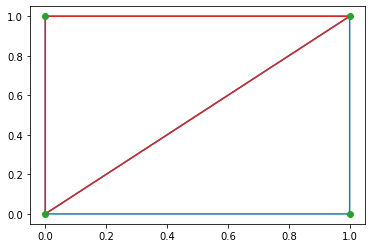

In [0]:
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

points = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
tri = Delaunay(points)

print(tri.simplices)

plt.triplot(points[:,0], points[:,1])
plt.plot(points[:,0], points[:,1], 'o')

subpart = points[tri.simplices[0,:]]
tri2 = Delaunay(subpart)

print(tri2.simplices)
p = subpart[tri2.simplices[0:]][0]
print(p)
plt.triplot(p[:,0], p[:,1])

{'vertices': array([[0. , 0. ],
       [0. , 1. ],
       [1. , 1. ],
       [1. , 0. ],
       [0.5, 0.5]]), 'vertex_markers': array([[1],
       [1],
       [1],
       [1],
       [0]], dtype=int32), 'triangles': array([[1, 0, 4],
       [4, 3, 2],
       [3, 4, 0],
       [4, 2, 1]], dtype=int32)}
[0.  0.  1.  1.  0.5]


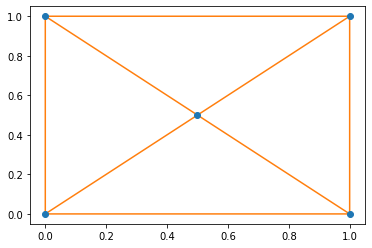

In [14]:
import triangle
import numpy as np
import matplotlib.pyplot as plt

v = np.array([[0, 0], [0, 1], [1, 1], [1, 0], [0.5,0.5]])
t = triangle.triangulate({'vertices': v})
print(t)
print(v[:,0])
plt.plot(v[:,0], v[:,1], 'o')
plt.triplot(v[:,0], v[:,1])


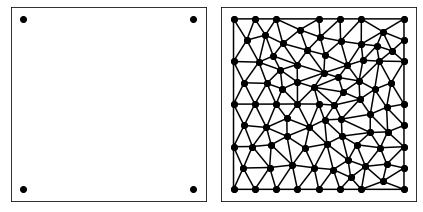

In [25]:
import triangle as tr
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A, 'qa0.01')
tr.compare(plt, A, B)
plt.show()